<div style="background-color: #e6e6fa; padding: 10px;">
    <h1>Introduction</h1>
</div>

This Kaggle notebook presents a comprehensive approach to predicting stroke likelihood using a dataset provided by the World Health Organization (WHO), which highlights stroke as the second leading cause of death globally. The analysis begins with the importation of essential Python libraries for data manipulation, visualization, and model building. It proceeds with preprocessing steps, including the removal of unnecessary columns, encoding of categorical variables, and normalization of data to prepare it for machine learning models.

The core of the notebook is the application of advanced ensemble machine learning models: CatBoostClassifier, LGBMClassifier, and XGBClassifier, which are known for their efficiency in handling categorical data and scalability. The notebook meticulously details the process of hyperparameter optimization using GridSearchCV for each model to ensure the best possible predictive performance. It also emphasizes the importance of cross-validation to assess the models' accuracy reliably.

Visualizations such as the correlation matrix heatmap provide insights into the relationships between different variables and their impact on the likelihood of a stroke. This analytical process is underpinned by a dataset encompassing various patient attributes, including demographic details, health conditions, and lifestyle factors, aiming to identify patterns and predictors of stroke risk.

This notebook serves as an educational resource for data scientists and medical professionals interested in applying machine learning techniques to healthcare data.


<div style="display: flex; justify-content: space-between; align-items: flex-start;">
    <div style="padding: 10px; width: 60%; text-align: right;">
        <img src="https://github.com/ocarhaci/images/blob/main/stroke.jpg?raw=true" alt="Stroke" style="width: 60%; height: auto;">
    </div>
</div>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


train=pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
train = train.drop(columns=['id'])
train

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


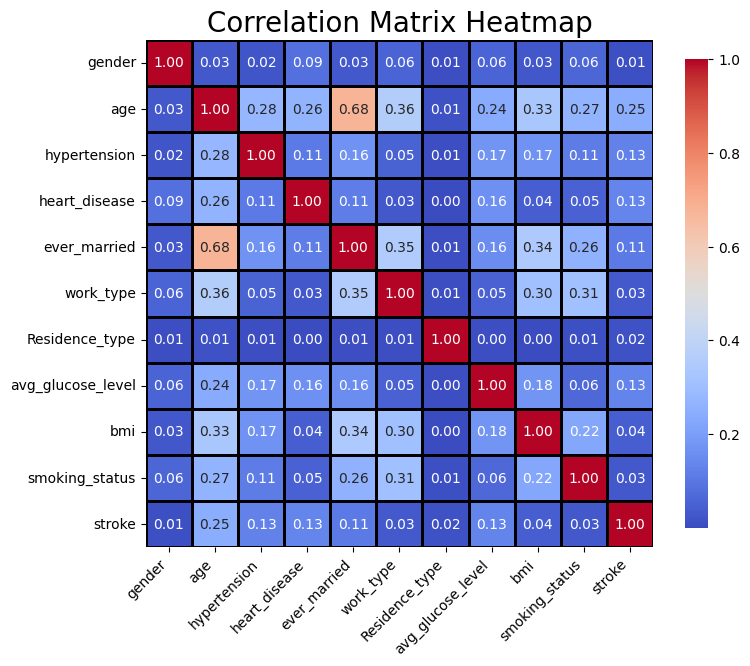

In [2]:
# Apply encoding to categorical variables and keep numerical variables unchanged
processed_data = train.apply(lambda column: LabelEncoder().fit_transform(column) if column.dtype == 'O' else column)

# Normalize the processed data
normalized_data = pd.DataFrame(StandardScaler().fit_transform(processed_data), columns=processed_data.columns)

# Calculate the absolute value correlation matrix
correlation_matrix_abs = abs(normalized_data.corr())

# Plotting the absolute value correlation matrix
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix_abs, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, linecolor='black', square=True, cbar_kws={"shrink": 0.65})
plt.title('Correlation Matrix Heatmap', fontsize=20)  
plt.xticks(fontsize=10, rotation=45, ha='right') 
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()



In [3]:
X_train=processed_data.drop(['stroke'], axis=1)
Y_train=processed_data['stroke']
X_train = pd.DataFrame(StandardScaler().fit_transform(X_train), columns=X_train.columns)

In [4]:
X_train

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1.188073,1.051434,-0.328602,4.185032,0.723884,-0.153836,0.984080,2.706375,0.981345,-0.351781
1,-0.840344,0.786070,-0.328602,-0.238947,0.723884,0.763438,-1.016178,2.121559,NaN,0.581552
2,1.188073,1.626390,-0.328602,4.185032,0.723884,-0.153836,-1.016178,-0.005028,0.459269,0.581552
3,-0.840344,0.255342,-0.328602,-0.238947,0.723884,-0.153836,0.984080,1.437358,0.701207,1.514885
4,-0.840344,1.582163,3.043196,-0.238947,0.723884,0.763438,-1.016178,1.501184,-0.623083,0.581552
...,...,...,...,...,...,...,...,...,...,...
5105,-0.840344,1.626390,3.043196,-0.238947,0.723884,-0.153836,0.984080,-0.494658,NaN,0.581552
5106,-0.840344,1.670617,-0.328602,-0.238947,0.723884,0.763438,0.984080,0.420775,1.414286,0.581552
5107,-0.840344,-0.363842,-0.328602,-0.238947,0.723884,0.763438,-1.016178,-0.511443,0.217332,0.581552
5108,1.188073,0.343796,-0.328602,-0.238947,0.723884,-0.153836,-1.016178,1.328257,-0.419346,-0.351781


In [5]:
def optimize_hyperparameters(model, param_grid, X_train, Y_train, cv_splits=5, random_state=1, verbose=1, n_jobs=-1):
    # Prepare the cross-validation procedure
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kf, verbose=verbose, n_jobs=n_jobs)
    
    # Fit GridSearchCV
    grid_search.fit(X_train, Y_train)
    
    # Return the best parameters and the best score
    return grid_search.best_params_, grid_search.best_score_

def run_model(model, X_train, Y_train):
    # Prepare the cross-validation procedure
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    # Evaluate the model
    accuracy = cross_val_score(model, X_train, Y_train, cv=kf, scoring='accuracy')

    # Calculate the average accuracy
    average_accuracy = accuracy.mean()

    # Print the results
    print("Accuracy for each fold:", accuracy)
    print("Average Accuracy across all folds:", average_accuracy)

In [6]:
catboost_param_grid = {
    'iterations': [100, 200],
    'depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.1, 0.2, 0.3],
    'loss_function': ['Logloss'],
}

catboost_model = CatBoostClassifier(eval_metric='Accuracy', random_seed=1, verbose=0)
best_params_catboost, best_score_catboost = optimize_hyperparameters(catboost_model, catboost_param_grid, X_train, Y_train)

print("--------------------------------------------------------------------") # use as separator
print("CatBoost Best Parameters:", best_params_catboost)
print("CatBoost Best Accuracy:", best_score_catboost)
print("--------------------------------------------------------------------") # use as separator

#----------------------------------------------------------------------------------------------------------------------------#

LGBM_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.1, 0.2, 0.3],
    'objective': ['binary'],  
}

# Initialize the model
model = LGBMClassifier(random_state=1, metric='binary_logloss', verbose=-1)
best_params_lgbm, best_score_lgbm = optimize_hyperparameters(model, LGBM_param_grid, X_train, Y_train)

# Print the best parameters and the accuracy of the model using these parameters
print("LGBM Best Parameters:", best_params_lgbm)
print("LGBM Best Accuracy:", best_score_lgbm)
print("--------------------------------------------------------------------") # use as separator

#----------------------------------------------------------------------------------------------------------------------------#

XGB_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.1, 0.2, 0.3],
    'objective': ['binary:logistic'],  # Objective is kept constant as we are focusing on binary classification
}

# Initialize the model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1)
best_params_XGB, best_score_XGB = optimize_hyperparameters(model, XGB_param_grid, X_train, Y_train)

# Print the best parameters and the accuracy of the model using these parameters
print("XGB Best Parameters:", best_params_XGB)
print("XGB Best Accuracy:", best_score_XGB)
print("--------------------------------------------------------------------") # use as separator

Fitting 5 folds for each of 30 candidates, totalling 150 fits
--------------------------------------------------------------------
CatBoost Best Parameters: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1, 'loss_function': 'Logloss'}
CatBoost Best Accuracy: 0.9518590998043053
--------------------------------------------------------------------
Fitting 5 folds for each of 30 candidates, totalling 150 fits
LGBM Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'binary'}
LGBM Best Accuracy: 0.9510763209393346
--------------------------------------------------------------------
Fitting 5 folds for each of 30 candidates, totalling 150 fits
XGB Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'binary:logistic'}
XGB Best Accuracy: 0.9512720156555773
--------------------------------------------------------------------


In [7]:
CatBoost_model = CatBoostClassifier(
    iterations=100, 
    depth=4, 
    learning_rate=0.1, 
    loss_function='Logloss', 
    eval_metric='Accuracy', 
    random_seed=1, 
    metric_period=100,
    verbose = 0
) 
run_model(CatBoost_model, X_train, Y_train)

Accuracy for each fold: [0.94031311 0.95499022 0.95890411 0.95009785 0.95499022]
Average Accuracy across all folds: 0.9518590998043053


In [8]:
LGBM_model = LGBMClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    objective='binary',
    random_state=1,
    metric='binary_logloss', 
    verbose=-1
)
run_model(LGBM_model, X_train, Y_train)

Accuracy for each fold: [0.94227006 0.95499022 0.95792564 0.94911937 0.95107632]
Average Accuracy across all folds: 0.9510763209393346


In [9]:
XGB_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=1
)
run_model(XGB_model, X_train, Y_train)

Accuracy for each fold: [0.94129159 0.95401174 0.95792564 0.95107632 0.95205479]
Average Accuracy across all folds: 0.9512720156555773


<div style="background-color: #e6e6fa; padding: 10px;">
    <h1>Analysis & Conclusion</h1>
</div>

The analysis of the stroke prediction dataset reveals several key insights and demonstrates the effectiveness of ensemble machine learning models in predicting stroke likelihood based on various patient attributes. The correlation analysis highlighted that age is significantly correlated with the likelihood of stroke, as well as with other health-related variables, confirming the importance of age as a risk factor for stroke. Interestingly, gender showed minimal correlation with other variables, suggesting that the risk of stroke is more closely tied to health conditions and lifestyle factors than to gender alone.

The optimization of hyperparameters for the CatBoost, LGBM, and XGB classifiers resulted in remarkably similar performance across all three models, with accuracy scores just above 95%. This level of accuracy is indicative of the models' robustness and their capability to generalize well on the dataset. Specifically, the best parameters identified for the CatBoost model were a depth of 4, 100 iterations, a learning rate of 0.1, and the Logloss loss function, yielding an accuracy of approximately 95.19%. The LGBM model achieved a best accuracy of about 95.11% with 100 n_estimators, a max_depth of 3, and a learning rate of 0.1. The XGB model, with parameters set to 100 n_estimators, a max_depth of 3, and a learning rate of 0.1, achieved a similar accuracy of 95.13%.

The cross-validation results further confirm the models' reliability, with each fold's accuracy closely matching the overall average accuracy for each model. These results underscore the potential of machine learning approaches in medical prediction tasks, offering a high degree of precision in identifying patients at risk of stroke.

In conclusion, the application of CatBoost, LGBM, and XGB classifiers to the stroke prediction dataset demonstrates the power of ensemble methods in handling complex, real-world healthcare datasets. By accurately identifying individuals at higher risk of stroke, these models can significantly contribute to preventative healthcare measures and potentially save lives. Future work could explore the integration of additional patient data, the application of alternative machine learning techniques, and the development of real-time prediction systems to further enhance stroke prediction accuracy and utility in clinical settings.